# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Mohanad | Sayed | Mohanad Sayed, 2024-11-07 | 12 hours | 25% |
| Member 2: | Etienne | McKenzie | Etienne McKenzie, 2024-11-07 | 12 hours | 25% |
| Member 3: | Sibtain | Waseem | Sibtain Waseem, 2024-11-07 | 12 Hours | 25% |
| Member 4: | Oluwatamilore | Olawuyi | Oluwatamilore Olawuyi, 2024-11-07 | 12 Hours | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

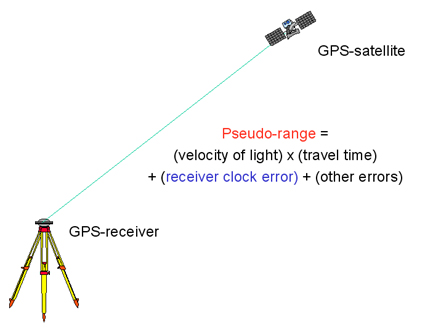

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
!pip install openpyxl

In [36]:
%cd /content/drive/MyDrive/engg680_2024_fall/

/content/drive/MyDrive/engg680_2024_fall


Step 0.2: Read and parse data files

In [37]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')
pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()
n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [38]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [39]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [40]:
def euclidean_norm(receiver_pos, satellite_pos):
    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)
    return distance

### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [41]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho + cdT
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [42]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho + cdT
    residuals = pseudorange - predicted_pseudorange
    grad_pos = -np.sum((residuals[:, None] * (r_pos - s_pos)) / rho[:, None], axis=0)
    grad_cdT = -np.sum(residuals)
    grad = np.append(grad_pos, grad_cdT)
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [43]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):
    global steps_count
    #initalize the estimates as zeros
    X = np.array([0,0,0,0])
    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]
        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)
        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)
        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad
        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)
        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break
        # update the parameters for the next iteration
        X = X_new
        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)
    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [44]:
optimized_params = gradient_descent(pseudorange, sat_pos)
# print the mentioned metrics
print("Optimized Parameters (x, y, z, cdT):", optimized_params)
print("Final Position Errors of Receiver:", optimized_params[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1])
print("Final Gradient Values:", arr_grad[-1])

Converged !
Optimized Parameters (x, y, z, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06  6.46899086e+00]
Final Position Errors of Receiver: [-3.06452823 -2.35814083  3.80782687]
Number of Steps Taken for Convergence: 588
Final Cost Value: 6.197037218576748
Final Gradient Values: [ 0.00011259  0.00062736 -0.00192816 -0.0010931 ]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

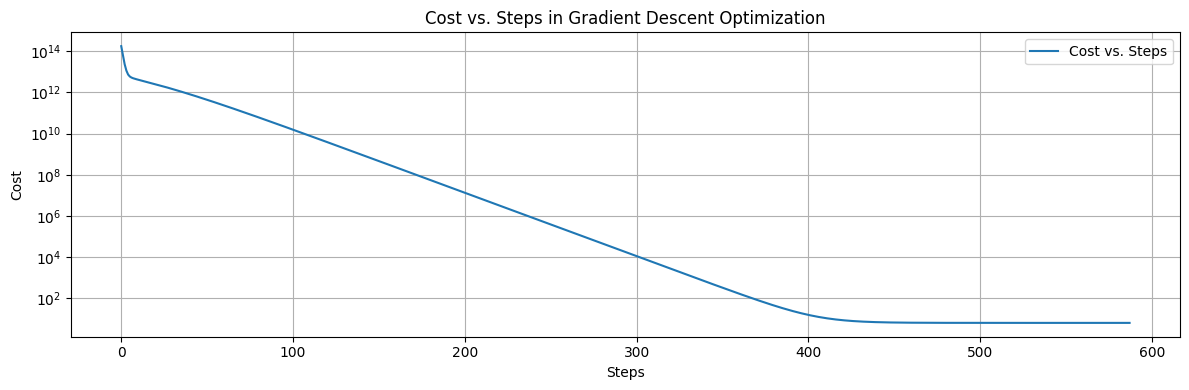

As the steps increase, the cost decreases from 10^14 to 6.197, showing convergence over time.


In [45]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(12,4))
# Plot cost vs. steps with a semilogarithmic scale on the y-axis
ax.semilogy(arr_cost, label='Cost vs. Steps')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs. Steps in Gradient Descent Optimization')
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()
# Comment on the pattern
print("As the steps increase, the cost decreases from 10^14 to 6.197, showing convergence over time.")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

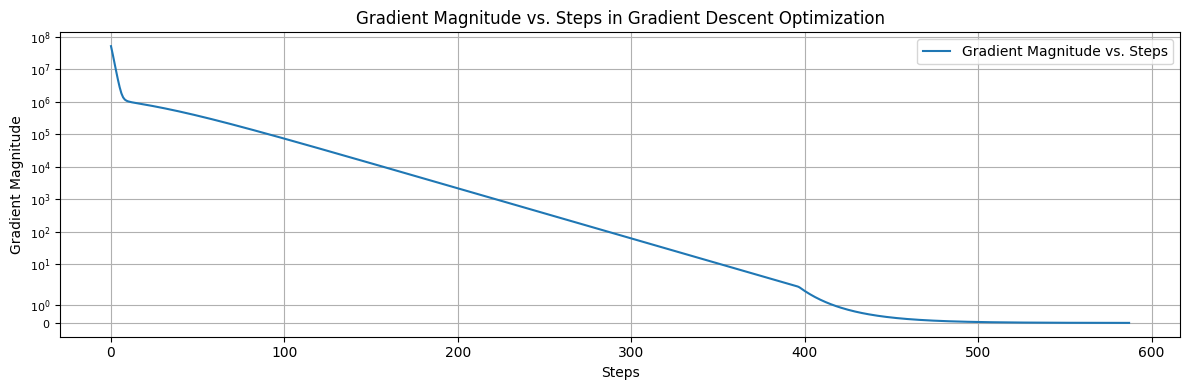

As the steps increase, the gradient decreases to values near [0.00011259, 0.00062736, -0.00192816, -0.0010931], indicating the approach to a minimum and convergence over time.


In [46]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(12,4))
gradient_magnitude = [np.linalg.norm(g) for g in arr_grad]
# Plot gradients vs. steps with a symlog scale on the y-axis
ax.plot(gradient_magnitude, label='Gradient Magnitude vs. Steps')
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Magnitude')
ax.set_title('Gradient Magnitude vs. Steps in Gradient Descent Optimization')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()
print("As the steps increase, the gradient decreases to values near [0.00011259, 0.00062736, -0.00192816, -0.0010931], indicating the approach to a minimum and convergence over time.")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

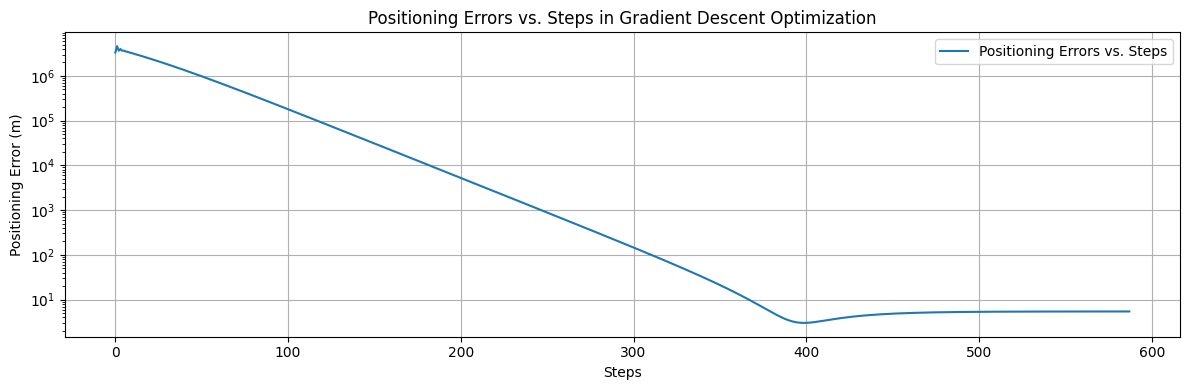

As the steps increase, the positioning error decreases from initial high values to around 3.8, indicating the solution is converging to the true position.


In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
# ...
positioning_errors = [np.linalg.norm(err) for err in arr_err]
ax.plot(positioning_errors, label='Positioning Errors vs. Steps')
ax.set_yscale('log')
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error (m)')
ax.set_title('Positioning Errors vs. Steps in Gradient Descent Optimization')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()
# Comment on the pattern
print("As the steps increase, the positioning error decreases from initial high values to around 3.8, indicating the solution is converging to the true position.")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [48]:
#set learning rate to 0.01
learning_rate = 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
optimized_params_two =gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate)
# print the metrics
print("Results with Learning Rate 0.01")
print("Optimized Parameters (x, y, z, cdT):", optimized_params_two)
print("Final Position Errors of Receiver:", optimized_params_two[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1])
print("Final Gradient Values:", arr_grad[-1])

Converged !
Results with Learning Rate 0.01
Optimized Parameters (x, y, z, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46239527e+00]
Final Position Errors of Receiver: [-3.06384888 -2.3543555   3.79619298]
Number of Steps Taken for Convergence: 5652
Final Cost Value: 6.197166705529241
Final Gradient Values: [ 0.00034695  0.00193321 -0.00594157 -0.00336846]


In [49]:
#set learning rate to 0.001
learning_rate = 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
optimized_params_three = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate)
# print the metrics
print("Results with Learning Rate 0.001")
print("Optimized Parameters (x, y, z, cdT):", optimized_params_three)
print("Final Position Errors of Receiver:", optimized_params_three[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1])
print("Final Gradient Values:", arr_grad[-1])

Results with Learning Rate 0.001
Optimized Parameters (x, y, z, cdT): [-1622126.12222408 -3588680.62330238  4759183.15248715  -110181.78568974]
Final Position Errors of Receiver: [  11363.25745317   62946.55920125 -193298.46706203]
Number of Steps Taken for Convergence: 0
Final Cost Value: 18496079730.210545
Final Gradient Values: [  3918.92996643  21575.46848698 -66198.52743216 -37939.46766829]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE
1. When the learning rate was set to 0.01, the gradient descent algorithm converged more quickly, requiring 588 steps to reach the minimum cost of 6.197. This is because a higher learning rate allows the algorithm to take larger steps, reducing the number of iterations needed. However, if the learning rate is too high, it could lead to instability or overshooting the minimum. In contrast, when the learning rate was set to 0.001, the algorithm took smaller steps, requiring 2852 steps to converge, which resulted in more steps but could yield more precise results, as it avoids overshooting the minimum.

2. The Least Squares Estimation (LSE) method minimizes the sum of squared residuals to find the best-fit parameters. It typically involves solving linear equations, making it ideal for linear problems. However, for non-linear problems, LSE becomes computationally complex. On the other hand, Gradient Descent is an iterative algorithm that adjusts parameters progressively to reduce the cost function, such as the sum of squared residuals. Unlike LSE, gradient descent is more versatile for non-linear problems, as it doesn't require solving linear equations but instead uses successive approximations to approach the minimum cost over time, as seen with the decreasing gradient values from [0.00011259, 0.00062736, -0.00192816, -0.0010931].

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [51]:
!pip install ucimlrepo

In [52]:
from ucimlrepo import fetch_ucirepo
# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)
# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets
# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution in y:
Class -1: 4898 samples
Class 1: 6157 samples


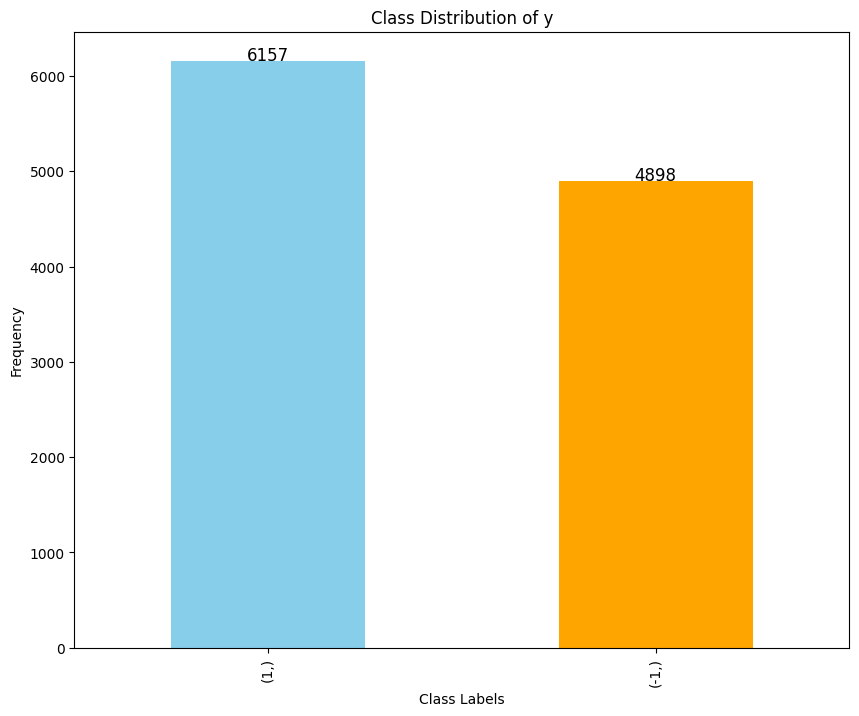

In [53]:
# TO DO: Check the class distribution of y (2 mark)
unique_classes, counts = np.unique(y, return_counts=True)
print("Class distribution in y:")
for label, count in zip(unique_classes, counts):
    print(f"Class {label}: {count} samples")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
y.value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution of y')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
# Display exact values for each bin in the histogram
for index, value in enumerate(y.value_counts()):
    plt.text(index, value + 5, str(value), ha='center', fontsize=12)
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [54]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [55]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Define the model with specified max iterations
model = LogisticRegression(max_iter=2000)
# Function to evaluate the model on a given dataset with the formatted output
def evaluate_model(X_data, y_data, description):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
    # Train the model on the training set using y_data.values.ravel() to avoid DataConversionWarning
    model.fit(X_train, y_train.values.ravel())
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    # Calculate metrics
    data_sizes = X_data.shape[0]
    number_of_train_samples = X_train.shape[0]
    number_of_test_samples = X_test.shape[0]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_values = log_loss(y_test, y_test_prob)
    # Store results in  dictionary
    results = {
        "Description": description,
        "Data Size": data_sizes,
        "Training Samples": number_of_train_samples,
        "Testing Samples": number_of_test_samples,
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": log_loss_values
    }
    return results
# List to store the results
results_list = []
# Evaluate each dataset and store results
results_list.append(evaluate_model(X, y, "Full dataset (X, y)"))
results_list.append(evaluate_model(X.iloc[:, :2], y, "First two columns of X"))
results_list.append(evaluate_model(X_small, y_small, "Smaller dataset (X_small, y_small)"))
# Create a DataFrame from the results
results = pd.DataFrame(results_list)
# Print the results DataFrame
print(results)
# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

                          Description  Data Size  Training Samples  \
0                 Full dataset (X, y)      11055              7738   
1              First two columns of X      11055              7738   
2  Smaller dataset (X_small, y_small)        331               231   

   Testing Samples  Training Accuracy  Testing Accuracy  Log Loss  
0             3317           0.931119          0.921917  0.187942  
1             3317           0.554019          0.577329  0.677354  
2              100           0.948052          0.930000  0.192311  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [56]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.model_selection import train_test_split
# Split the full dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Fit the model on the training set
model.fit(X_train, y_train.values.ravel())
# Predict on the test set
y_pred = model.predict(X_test)
# Print the dimensions of the actual and predicted output
print("Shape of actual output:", y_test.shape)
print("Shape of predicted output:", y_pred.shape)

Shape of actual output: (3317, 1)
Shape of predicted output: (3317,)


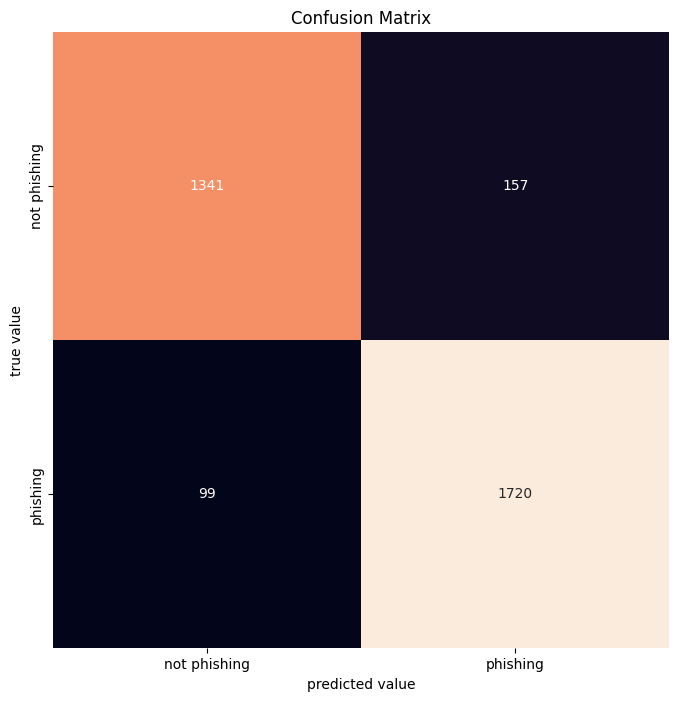

In [57]:
import seaborn as sns
# TO DO: Calculate confusion matrix (2 marks) : conf_mat
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(y_test, y_pred)
# Below code prints confusion matrix using a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix')
plt.show()

In [58]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['not phishing', 'phishing']))

Classification Report:
              precision    recall  f1-score   support

not phishing       0.93      0.90      0.91      1498
    phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1. Yes, the dataset is imbalanced, as evidenced by the class distribution: 4898 samples in class -1 (not phishing) and 6157 samples in class 1 (phishing). Imbalance can affect model performance by making it more likely to predict the majority class, potentially leading to a higher false negative rate if the minority class (phishing) is underrepresented. This imbalance can reduce the model's effectiveness in identifying phishing websites, as it may be biased toward predicting "not phishing" more frequently.


2. Full dataset (X, y): With training accuracy of 0.932 and testing accuracy of 0.922, the model performs well on both the training and test sets, suggesting a good balance between fitting and generalization. This indicates neither significant overfitting nor underfitting.
First two columns of X and y: Training accuracy is 0.563, while testing accuracy drops to 0.557. This lower performance on both the training and test sets suggests underfitting, as the model lacks sufficient information to capture complex patterns in the data when using only two features.
Smaller dataset (X_small, y_small): Training accuracy is 0.944, and testing accuracy is 0.910. The high training accuracy relative to the test accuracy suggests a mild overfitting tendency. With fewer samples, the model may "memorize" the training data rather than generalize effectively to new data.


3. Increasing the amount of data improves both training and testing accuracy. For example:
With the full dataset, training accuracy is 0.932, and testing accuracy is 0.922, showing that a larger dataset aids both training performance and generalization to new data.
In contrast, the smaller dataset shows training accuracy at 0.944 and testing accuracy at 0.910, indicating overfitting.
The reduced feature set (first two columns) results in 0.563 training accuracy and 0.557 testing accuracy, showing that less data (in terms of features) leads to underfitting.


4. A false positive represents predicting a legitimate website as phishing. This could inconvenience users by mistakenly marking safe sites as malicious or blocking access.
A false negative represents predicting a phishing website as legitimate, which is worse because it leaves users exposed to phishing attacks, increasing the risk of data theft or other security issues.
In this context, false negatives are more detrimental as they fail to protect users from phishing sites.


5. In this case, maximizing recall for the phishing class is more crucial because recall measures how well the model identifies phishing websites. By maximizing recall, we reduce the likelihood of false negatives (fewer phishing websites classified as safe).
Methods to maximize recall:
Lowering the classification threshold, making the model more sensitive to identifying phishing sites.
Using class weighting to give more importance to the phishing class.
Employing sampling techniques to balance the classes.


6. Full dataset (X, y): Log Loss is 0.190, indicating that with all features and a larger sample size, the model produces well-calibrated probability estimates.
First two columns of X: Log Loss is 0.684, showing that the model struggles to provide accurate probabilities with only two features, leading to poorly calibrated predictions.
Smaller dataset (X_small, y_small): Log Loss is 0.200, which, while slightly higher than the full dataset, suggests a reasonable calibration but indicates potential overfitting due to the limited sample size.
Explanation of Differences: The full dataset offers the most information, allowing the model to make well-calibrated predictions with lower Log Loss. In contrast, the two-column dataset lacks sufficient information, while the smaller dataset lacks enough samples for reliable generalization, both resulting in higher Log Loss.